# PAI Assignment 3
Student: Georgy Andryushchenko 

For text classification I've chosen to build and train a BiLSTM model using Tensorflow. Since I have a little experience in building such models I used the help of [this tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn).

In [ ]:
!wget https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/smsspamcollection.zip?raw=true -O smsspamcollection.zip

In [ ]:
!unzip smsspamcollection.zip

Archive:  smsspamcollection.zip
  inflating: readme                  
  inflating: SMSSpamCollection.txt   


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

### Data Preparation

In [ ]:
# read data from file
df = pd.read_csv('SMSSpamCollection.txt', sep='\t', names=['label', 'text'])
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
# encode label column
df['label'] = df['label'].astype('category').cat.codes
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [ ]:
# compose tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(df['text'].values, tf.string),
        tf.cast(df['label'].values, tf.int8)
    )
)

In [ ]:
# split dataset as 90/10
TRAIN_SIZE = int(0.9 * len(dataset))

train_dataset = dataset.take(TRAIN_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE)

In [ ]:
# create batches
BATCH_SIZE = 15

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Building Model

The model has the following architecture. It takes the sentence, maps indices from the encoder vocabulary to the words, and produces trainable embedding vector for each input word. The embedding vectors are processed by bidirectional LSTM layer. Fully connected(Dense) layer does classification afterwards.

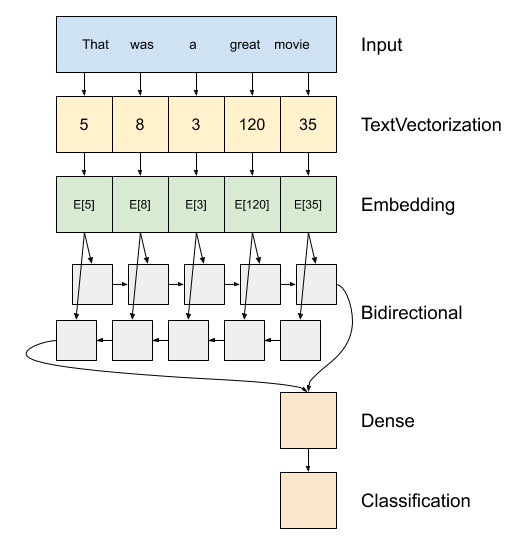

In [ ]:
# create encoder
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
len(encoder.get_vocabulary())

1000

In [ ]:
encoder

In [ ]:
# compose model architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True # enable to handle variable sequence lengths
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
# provide loss, optimizer, and metric
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

### Training

In [ ]:
# train the model with 10 epochs
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
335/335 [==============================] - 21s 22ms/step - loss: 0.4899 - accuracy: 0.8654 - val_loss: 0.2515 - val_accuracy: 0.8733
Epoch 2/10
335/335 [==============================] - 5s 15ms/step - loss: 0.1398 - accuracy: 0.9499 - val_loss: 0.0705 - val_accuracy: 0.9778
Epoch 3/10
335/335 [==============================] - 5s 15ms/step - loss: 0.0764 - accuracy: 0.9781 - val_loss: 0.0536 - val_accuracy: 0.9822
Epoch 4/10
335/335 [==============================] - 5s 15ms/step - loss: 0.0568 - accuracy: 0.9836 - val_loss: 0.0463 - val_accuracy: 0.9822
Epoch 5/10
335/335 [==============================] - 6s 17ms/step - loss: 0.0443 - accuracy: 0.9866 - val_loss: 0.0439 - val_accuracy: 0.9822
Epoch 6/10
335/335 [==============================] - 5s 15ms/step - loss: 0.0354 - accuracy: 0.9890 - val_loss: 0.0444 - val_accuracy: 0.9844
Epoch 7/10
335/335 [==============================] - 5s 15ms/step - loss: 0.0283 - accuracy: 0.9902 - val_loss: 0.0460 - val_accuracy: 0.984

### Testing

In [ ]:
# take a look at the texts and true labels from the first testing batch 
for example, label in test_dataset.take(1):
  print('texts: ', example.numpy()[:10])
  print()
  print('labels: ', label.numpy()[:10])

texts:  [b'Uncle G, just checking up on you. Do have a rewarding month'
 b"Hello boytoy ! Geeee ... I'm missing you today. I like to send you a tm and remind you I'm thinking of you ... And you are loved ... *loving kiss*"
 b'I think the other two still need to get cash but we can def be ready by 9'
 b'Hey gals...U all wanna meet 4 dinner at n\xc3\xacte? '
 b"Dear 0776xxxxxxx U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18yrs"
 b'Babe ! What are you doing ? Where are you ? Who are you talking to ? Do you think of me ? Are you being a good boy? Are you missing me? Do you love me ?'
 b'Great! How is the office today?'
 b"It's cool, we can last a little while. Getting more any time soon?"
 b':-( sad puppy noise'
 b'Yes its possible but dint try. Pls dont tell to any one k']

labels:  [0 0 0 0 1 0 0 0 0 0]


In [ ]:
# compute loss and accuracy on the testing dataset
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

38/38 [==============================] - 0s 6ms/step - loss: 0.0766 - accuracy: 0.9803
Test Loss: 0.07655183225870132
Test Accuracy: 0.980286717414856


In [ ]:
# show predictions for the first testing batch
print('Prediction(isSpam?) - Text')
print("======================================")
for example, label in test_dataset.take(1):
    texts = example.numpy()
    predictions = model.predict(np.array(texts)) >= 0
    for i in range(len(texts)):
        print(predictions[i, 0], '-', texts[i])

Prediction(isSpam?) - Text
False - b'Uncle G, just checking up on you. Do have a rewarding month'
False - b"Hello boytoy ! Geeee ... I'm missing you today. I like to send you a tm and remind you I'm thinking of you ... And you are loved ... *loving kiss*"
False - b'I think the other two still need to get cash but we can def be ready by 9'
False - b'Hey gals...U all wanna meet 4 dinner at n\xc3\xacte? '
True - b"Dear 0776xxxxxxx U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18yrs"
False - b'Babe ! What are you doing ? Where are you ? Who are you talking to ? Do you think of me ? Are you being a good boy? Are you missing me? Do you love me ?'
False - b'Great! How is the office today?'
False - b"It's cool, we can last a little while. Getting more any time soon?"
False - b':-( sad puppy noise'
False - b'Yes its possible but dint try. Pls dont tell to any one k'
False - b"Anyway holla at me whenever you're